In [106]:
#!/usr/bin/env python
import torch
import various_data_functions
from torch import nn
from torch import optim
from torch import Tensor
from torch.nn import functional as F
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt

#Setting plot parameters
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]

#Number of data points
N=10**3

In [144]:
#Base functions adapted from the practicals
def train_model(model, train_input, train_target,train_classes, mini_batch_size, test_input=None, test_target=None, crit=nn.CrossEntropyLoss, eta = 1e-3, nb_epochs = 50,print_=False, store_loss = False, aux_factor=1, store_error=False, checkpoint_name=None):
    #Initializing the loss, the optimizer, and the stored loss and errors for the plots
    criterion = crit()
    optimizer = optim.Adam(model.parameters(), lr=eta)
    stored_loss = []
    stored_error = []
    
    #Retrieving data if a similar model has already been trained or partially trained
    nb_epochs_finished = 0
    if checkpoint_name!=None:
        try:
            checkpoint = torch.load(checkpoint_name)
            nb_epochs_finished = checkpoint['nb_epochs_finished']
            model.load_state_dict(checkpoint['model_state'])
            optimizer.load_state_dict(checkpoint['optimizer_state'])
            if print_:
                print(f'Checkpoint loaded with {nb_epochs_finished} epochs finished.')
            stored_loss=checkpoint['stored_loss']
            if len(stored_loss)>nb_epochs*3:
                stored_loss=stored_loss[0:nb_epochs*3]
            stored_error=checkpoint['stored_error']
            if len(stored_error)>nb_epochs:
                stored_error=stored_error[0:nb_epochs]
        except FileNotFoundError:
            if print_:
                print('Starting from scratch.')
        except:
            print('Error when loading the checkpoint.')
            exit(1)
    
    #Training the network if the checkpoint wasn't fully trained
    for e in range(nb_epochs_finished,nb_epochs):
        
        #Initializing accumulated losses
        #loss1 is the loss over the output (identifying which number is greater)
        #loss2 and loss3 are the auxiliary losses trying to identify the numbers in the 2 input pictures
        acc_loss = 0
        acc_loss1 = 0
        acc_loss2 = 0
        acc_loss3 = 0
        
        #permuting the samples
        permuted_index = torch.randperm(train_input.size()[0])
        train_input_shuffled = train_input[permuted_index]
        train_target_shuffled = train_target[permuted_index]
        train_classes_shuffled = train_classes[permuted_index]
        
        
        for b in range(0, train_input.size(0), mini_batch_size):
            
            #forward pass
            output,aux_output = model(train_input_shuffled.narrow(0, b, mini_batch_size))
            if crit==nn.MSELoss:
                
                #computing the different losses
                loss1 = criterion(output[:,1], train_target_shuffled.narrow(0, b, mini_batch_size))
                loss2 = criterion(torch.argmax(aux_output[:,0:9],dim=1), train_classes_shuffled[:,0].narrow(0, b, mini_batch_size))
                loss3 = criterion(torch.argmax(aux_output[:,10:19],dim=1), train_classes_shuffled[:,1].narrow(0, b, mini_batch_size))
                loss = loss1 + loss2 + loss3
                print('|| loss1 req grad =', loss1.requires_grad, '|| loss2 req grad =',loss2.requires_grad,'|| loss3 req grad =', loss3.requires_grad)
            elif crit==nn.CrossEntropyLoss:
                loss1 = criterion(output, train_target_shuffled.narrow(0, b, mini_batch_size))
                loss2 = criterion(aux_output[:,0,:], train_classes_shuffled[:,0].narrow(0, b, mini_batch_size))
                loss3 = criterion(aux_output[:,1,:], train_classes_shuffled[:,1].narrow(0, b, mini_batch_size))
                loss = loss1 + aux_factor*(loss2 + loss3)
            else:
                print("Loss not implemented")
                
            #Update the accumulated losses
            acc_loss = acc_loss + loss.item()
            acc_loss1 = acc_loss1 + loss1.item()
            acc_loss2 = acc_loss2 + loss2.item()
            acc_loss3 = acc_loss3 + loss3.item()
            
            #zero the gradients
            model.zero_grad()
            
            #backward pass
            loss.backward()
            
            #optimizer step
            optimizer.step()
            
        #update the stored losses and error if needed
        if store_loss:
            stored_loss += [[acc_loss1], [acc_loss2], [acc_loss3]]
        if store_error:
            stored_error +=[compute_nb_errors(model, test_input, test_target, mini_batch_size)]
            
        #print the different losses if needed
        if print_:
            print(e, 'tot loss', acc_loss, 'loss1', acc_loss1, 'loss2', acc_loss2, 'loss3', acc_loss3)
            
        #save the checkpoint for later if needed
        if checkpoint_name!=None:
                checkpoint = {'nb_epochs_finished': e + 1,'model_state': model.state_dict(),'optimizer_state': optimizer.state_dict(),'stored_loss':stored_loss,'stored_error':stored_error}
                torch.save(checkpoint, checkpoint_name)
        
    #return the stored quantities  
    return torch.tensor(stored_loss),torch.tensor(stored_error)

#error computing function
def compute_nb_errors(model, input, target, mini_batch_size=100):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output , aux_output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[b + k]!=predicted_classes[k]:
                nb_errors = nb_errors + 1

    return nb_errors

#this function lets us do multiple runs more easily
def run_many_times(model,crit=nn.CrossEntropyLoss,mini_batch_size=100,n=10,print_=True,eta=1e-3,nb_epochs=25,aux_factor=0,shuffle=True, store_error=False,checkpoint_name=None):
    average_error=0
    losses=torch.empty(0,nb_epochs,3)
    errors=torch.empty(0,nb_epochs)
    for i in range(n):
        m=model()
        train_input,train_target,train_classes,test_input,test_target,test_classes=various_data_functions.data(N,True,False,nn.CrossEntropyLoss,shuffle=shuffle)
        if checkpoint_name!=None:
            checkpoint_name_spec=checkpoint_name+'try_'+str(i)+'.pth'
        else:
            checkpoint_name_spec=None
        new_losses,new_errors=train_model(m, train_input, train_target,train_classes,mini_batch_size,test_input=test_input, test_target=test_target,crit=crit,eta=eta,nb_epochs=nb_epochs,aux_factor=aux_factor,store_loss=True,store_error=store_error,checkpoint_name=checkpoint_name_spec)
        new_losses=new_losses.view(1,nb_epochs, 3)
        if store_error:
            new_errors= new_errors.view(1,nb_epochs)
            errors = torch.cat((errors,new_errors),0)
        if print_:
            losses = torch.cat((losses, new_losses), 0)
            nb_test_errors = compute_nb_errors(m, test_input, test_target, mini_batch_size)
            print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))
            average_error+=(100 * nb_test_errors) / test_input.size(0)
    if print_:
        print("Average error: "+str(average_error/n))
        avg_losses=torch.sum(losses,0)/n
        mod=int(torch.floor(torch.Tensor([nb_epochs/20])))
        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
        x_lab=torch.arange(nb_epochs)
        x_labels=x_lab[x_lab%mod==0].detach().numpy()
        ax0.errorbar(x_labels, avg_losses[x_lab%mod==0,0].detach().numpy(), yerr=torch.std(losses[:,:,0],0)[x_lab%mod==0].detach().numpy(), fmt='-o')
        ax0.set_title('evolution of the cross entropy loss')
        ax1.errorbar(x_labels, avg_losses[x_lab%mod==0,1].detach().numpy(), yerr=torch.std(losses[:,:,1],0)[x_lab%mod==0].detach().numpy(), fmt='o')
        ax1.errorbar(x_labels, avg_losses[x_lab%mod==0,2].detach().numpy(), yerr=torch.std(losses[:,:,2],0)[x_lab%mod==0].detach().numpy(), fmt='o')
        ax1.set_title('evolution of the auxiliary losses')
        plt.show()
    if store_error:
        return errors

#this function returns the number of parameters of a model
def n_params(model):
    n = 0
    for params in model.parameters():
        n += params.numel()
    return n

#this function uses the previous ones to build a big plot with several models
def big_error_plot(models,model_names,n=50,nb_epochs=100,eta=1e-3,name="big_error_plot.png",aux_factor=1):
    x_lab=torch.arange(nb_epochs)
    x_labels=x_lab.detach().numpy()
    for i in range(len(models)):
        print("Starting model " + model_names[i])
        errors=run_many_times(models[i],crit=nn.CrossEntropyLoss,mini_batch_size=10,n=n,print_=False,eta=eta,nb_epochs=nb_epochs,aux_factor=aux_factor,shuffle=True, store_error=True,checkpoint_name='checkpoints/'+model_names[i]+'_'+str(aux_factor).replace('.','')+'_')
        #sns.relplot(x="timepoint", y="signal", col="region",hue="event", style="event", kind="line",)
        #plt.errorbar(x_labels,(errors.mean(dim=0)[x_lab%mod==0]/10).detach().numpy(),yerr=(torch.std(errors,dim=0)[x_lab%mod==0]/10).detach().numpy(),fmt='o')
        mean=(errors.mean(dim=0)/10).detach().numpy()
        std=(torch.std(errors,dim=0)/10).detach().numpy()
        plt.plot(x_labels,mean)
        plt.fill_between(x_labels,mean-std,mean+std,alpha=0.2)
        print('Mean number of errors after '+str(nb_epochs)+' epochs of training: '+str(errors.mean(dim=0)[-1])+' out of 1000 test samples with a standard deviation of '+str(torch.std(errors,dim=0)[-1]))
    plt.ylabel('Accuracy[%]')
    plt.xlabel('Number of epochs')
    plt.legend(model_names)
    plt.savefig(name,bbox_inches='tight')
    plt.show()

In [108]:
shuffle = True
train_input,train_target,train_classes,test_input,test_target,test_classes=various_data_functions.data(N,True,False,nn.CrossEntropyLoss,shuffle=shuffle)

In [109]:
after = (14-3+1)/3
int(after), int(after**2*208)

(4, 3328)

In [110]:
class C1L2(nn.Module):
    def __init__(self):
        super().__init__()
                
        #convolutions.
        self.conv1 = nn.Conv2d(2, 144, kernel_size=3,groups=2)
        
        #define the half lenght of the output (linearized) after the last convolution
        self.h = int(4**2*144/2)
        
        #linear layers for the auxiliary losses
        self.aux_linear1 = nn.Linear(self.h, 10)
        self.aux_linear2 = nn.Linear(self.h, 10)
        
        #linear layers for the final output
        self.fc1 = nn.Linear(2*self.h, 20)
        self.fc2 = nn.Linear(20, 2)
        

    def forward(self, x):
        
        #computing the convolution
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = x.view(-1, 2*self.h)
        
        #computing the linear+softmax to make the auxiliary output
        #deviding the tensor 
        a1 = x.narrow(1, 0,      self.h)
        a2 = x.narrow(1, self.h, self.h)
                
        #computing the auxiliary output
        a1 = F.softmax(self.aux_linear1(a1), dim = 1).unsqueeze(1)
        a2 = F.softmax(self.aux_linear2(a2), dim = 1).unsqueeze(1)
        #merging the vector to return the final auxiliary output
        aux_output = torch.cat((a1, a2), 1)
        
        #computing the layers for the final output
        x = F.relu(self.fc1(x))
        output = F.softmax(self.fc2(x), dim=1)
        return output, aux_output

In [111]:
#checks
model = C1L2()
x = train_input[0:5]
output, aux_output = model(x)
output.shape, aux_output

(torch.Size([5, 2]),
 tensor([[[0.0805, 0.0780, 0.0994, 0.1311, 0.0922, 0.0841, 0.0543, 0.1191,
           0.1857, 0.0756],
          [0.0245, 0.1147, 0.1287, 0.1461, 0.0397, 0.1115, 0.0363, 0.1156,
           0.1316, 0.1513]],
 
         [[0.0989, 0.0937, 0.0934, 0.2087, 0.0667, 0.0964, 0.0464, 0.1183,
           0.1049, 0.0725],
          [0.0146, 0.0638, 0.1593, 0.2085, 0.0181, 0.1663, 0.0292, 0.0802,
           0.1486, 0.1114]],
 
         [[0.1451, 0.0685, 0.0728, 0.1963, 0.0665, 0.0744, 0.0475, 0.1286,
           0.1249, 0.0754],
          [0.0248, 0.0748, 0.1211, 0.1418, 0.0635, 0.1312, 0.0440, 0.0863,
           0.2061, 0.1065]],
 
         [[0.0566, 0.0779, 0.0861, 0.2198, 0.0871, 0.1082, 0.0587, 0.0837,
           0.1571, 0.0647],
          [0.0267, 0.0771, 0.1737, 0.1175, 0.0571, 0.1528, 0.0485, 0.0740,
           0.1700, 0.1026]],
 
         [[0.0741, 0.0732, 0.0828, 0.2120, 0.0622, 0.0958, 0.0570, 0.1478,
           0.1291, 0.0661],
          [0.0446, 0.0701, 0.1263, 0.169

In [112]:
##########################################################


In [113]:
class C1L3(nn.Module):
    def __init__(self):
        super().__init__()
        
        #convolutions
        self.conv1 = nn.Conv2d(2, 30, kernel_size=3,groups=2)
        
        #define the half lenght of the output (linearized) after the last convolution
        self.h = int(4**2*30/2)
        
        #linear layers for the auxiliary losses
        self.aux_linear1 = nn.Linear(self.h, 10)
        self.aux_linear2 = nn.Linear(self.h, 10)
        
        #linear layers for the final output
        self.fc1 = nn.Linear(2*self.h, 128)
        self.fc2 = nn.Linear(128, 20)
        self.fc3 = nn.Linear(20, 2)

    def forward(self, x):
        
        #computing the convolution
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = x.view(-1, 2*self.h)
        
        #computing the linear+softmax to make the auxiliary output
        #deviding the tensor 
        a1 = x.narrow(1, 0,      self.h)
        a2 = x.narrow(1, self.h, self.h)
                
        #computing the output
        a1 = F.softmax(self.aux_linear1(a1), dim = 1).unsqueeze(1)
        a2 = F.softmax(self.aux_linear2(a2), dim = 1).unsqueeze(1)
        #merging the vector to return the final auxiliary output
        aux_output = torch.cat((a1, a2), 1)
        
        #computing the layers for the final output
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = F.softmax(self.fc3(x),dim=1)
        return output, aux_output

In [114]:
#checks
model = C1L3()
x = train_input[0:5]
output, aux_output = model(x)
output.shape, aux_output.shape

(torch.Size([5, 2]), torch.Size([5, 2, 10]))

In [115]:
############################################

In [116]:
4**2*20

320

In [117]:
class C1L5(nn.Module):
    def __init__(self):
        super().__init__()
        
        #convolutions.
        self.conv1 = nn.Conv2d(2, 20, kernel_size=3,groups=2)
        
        #define the half lenght of the output (linearized) after the last convolution
        self.h = int(4**2*20/2)
        
        #linear layers for the auxiliary losses
        self.aux_linear1 = nn.Linear(self.h, 10)
        self.aux_linear2 = nn.Linear(self.h, 10)
        
        #linear layers for the final output
        self.fc1 = nn.Linear(2*self.h, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80,40)
        self.fc4 = nn.Linear(40,20)
        self.fc5 = nn.Linear(20, 2)

    def forward(self, x):
        
        #computing the convolution
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = x.view(-1, 2*self.h)
        
        #computing the linear+softmax to make the auxiliary output
        #deviding the tensor 
        a1 = x.narrow(1, 0,      self.h)
        a2 = x.narrow(1, self.h, self.h)
                
        #computing auxiliarythe output
        a1 = F.softmax(self.aux_linear1(a1), dim = 1).unsqueeze(1)
        a2 = F.softmax(self.aux_linear2(a2), dim = 1).unsqueeze(1)
        #merging the vector to return the final auxiliary output
        aux_output = torch.cat((a1, a2), 1)
        
        #computing the layers for the final output
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        output = F.softmax(self.fc5(x),dim=1)
        return output, aux_output

In [118]:
#checks
model = C1L5()
x = train_input[0:5]
output, aux_output = model(x)
output.shape, aux_output.shape

(torch.Size([5, 2]), torch.Size([5, 2, 10]))

In [119]:
#######################################################

In [120]:
class C2L2(nn.Module):
    def __init__(self):
        super().__init__()
        
        #convolutions
        self.conv1 = nn.Conv2d(2, 44, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(44, 220, kernel_size=3, groups = 2)
        
        #define the half lenght of the output (linearized) after the last convolution
        self.h = int(2**2*220/2)
        
        #linear layers for the auxiliary losses
        self.aux_linear1 = nn.Linear(self.h, 10)
        self.aux_linear2 = nn.Linear(self.h, 10)
        
        #linear layers for the final output
        self.fc1 = nn.Linear(2*self.h, 20)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        
        #computing the convolution
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = x.view(-1, 2*self.h)
        
        #computing the linear+softmax to make the auxiliary output
        #deviding the tensor 
        a1 = x.narrow(1, 0,      self.h)
        a2 = x.narrow(1, self.h, self.h)
                
        #computing auxiliarythe output
        a1 = F.softmax(self.aux_linear1(a1), dim = 1).unsqueeze(1)
        a2 = F.softmax(self.aux_linear2(a2), dim = 1).unsqueeze(1)
        #merging the vector to return the final auxiliary output
        aux_output = torch.cat((a1, a2), 1)
        
        #computing the layers for the final output
        x = F.relu(self.fc1(x))
        output = F.softmax(self.fc2(x), dim=1)
        return output, aux_output

In [121]:
#checks
model = C2L2()
x = train_input[0:5]
output, aux_output = model(x)
output.shape, aux_output.shape

(torch.Size([5, 2]), torch.Size([5, 2, 10]))

In [122]:
#######################################################

In [123]:
class C2L3(nn.Module):
    def __init__(self):
        super().__init__()
        
        #convolutions
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3,groups=2)
        
        #define the half lenght of the output (linearized) after the last convolution
        self.h = int(2**2*128/2)
        
        #linear layers for the auxiliary losses
        self.aux_linear1 = nn.Linear(self.h, 10)
        self.aux_linear2 = nn.Linear(self.h, 10)
        
        #linear layers for the final output
        self.fc1 = nn.Linear(2*self.h, 60)
        self.fc2 = nn.Linear(60, 20)
        self.fc3 = nn.Linear(20, 2)

    def forward(self, x):
        
        #computing the convolution
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = x.view(-1, 2*self.h)
        
        #computing the linear+softmax to make the auxiliary output
        #deviding the tensor 
        a1 = x.narrow(1, 0,      self.h)
        a2 = x.narrow(1, self.h, self.h)
                
        #computing auxiliarythe output
        a1 = F.softmax(self.aux_linear1(a1), dim = 1).unsqueeze(1)
        a2 = F.softmax(self.aux_linear2(a2), dim = 1).unsqueeze(1)
        #merging the vector to return the final auxiliary output
        aux_output = torch.cat((a1, a2), 1)
        
        #computing the layers for the final output
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = F.softmax(self.fc3(x), dim=1)
        return output, aux_output

In [124]:
#checks
model = C2L3()
x = train_input[0:5]
output, aux_output = model(x)
output.shape, aux_output.shape

(torch.Size([5, 2]), torch.Size([5, 2, 10]))

In [125]:
class C3L2(nn.Module):
    def __init__(self):
        super().__init__()
        self.p=12
        #convolutions
        self.conv1 = nn.Conv2d(2, 2*self.p, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(2*self.p, 4*self.p, kernel_size=3,groups=2)
        self.conv3 = nn.Conv2d(4*self.p, 8*self.p, kernel_size=3,groups=2)
        
        #define the half lenght of the output (linearized) after the last convolution
        self.h = int(4**2*8*self.p/2)
        
        #linear layers for the auxiliary losses
        self.aux_linear1 = nn.Linear(self.h, 10)
        self.aux_linear2 = nn.Linear(self.h, 10)
        
        #linear layers for the final output
        self.fc1 = nn.Linear(2*self.h, 20)
        self.fc2 = nn.Linear(20, 2)

        
    def forward(self, x):
        
        #computing the convolution
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(F.max_pool2d(self.conv3(x), kernel_size=2, stride=2))     
        x = x.view(-1, 2*self.h)
        
        #computing the linear+softmax to make the auxiliary output
        #deviding the tensor 
        a1 = x.narrow(1, 0,      self.h)
        a2 = x.narrow(1, self.h, self.h)
                
        #computing auxiliarythe output
        a1 = F.softmax(self.aux_linear1(a1), dim = 1).unsqueeze(1)
        a2 = F.softmax(self.aux_linear2(a2), dim = 1).unsqueeze(1)
        #merging the vector to return the final auxiliary output
        aux_output = torch.cat((a1, a2), 1)
        
        #computing the layers for the final output
        x = F.relu(self.fc1(x))
        output = F.softmax(self.fc2(x), dim=1)
        return output, aux_output

In [126]:
#checks
model = C3L2()
x = train_input[0:5]
output, aux_output = model(x)
output.shape, aux_output.shape

(torch.Size([5, 2]), torch.Size([5, 2, 10]))

In [127]:
class C4L2_bis(nn.Module):#bis got switched, be careful
    def __init__(self):
        super().__init__()
        self.p=7
        #convolutions
        self.conv1 = nn.Conv2d(2, 2*self.p, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(2*self.p, 4*self.p, kernel_size=3,groups=2)
        self.conv3 = nn.Conv2d(4*self.p, 8*self.p, kernel_size=3,groups=2)
        self.conv4 = nn.Conv2d(8*self.p, 16*self.p, kernel_size=3,groups=2)
        
        #hidden layer parameter
        self.h = int(3**2*16*self.p/2)
        
        #linear layers for the auxiliary losses
        self.aux_linear1 = nn.Linear(self.h, 10)
        self.aux_linear2 = nn.Linear(self.h, 10)
        
        #linear layers for the final output
        self.fc1 = nn.Linear(2*self.h, 20)
        self.fc2 = nn.Linear(20, 2)

        
    def forward(self, x):
        
        #computing the convolution
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(F.max_pool2d(self.conv4(x), kernel_size=2, stride=2))
        x = x.view(-1, 2*self.h)
        
        #computing the linear+softmax to make the auxiliary output
        #deviding the tensor 
        a1 = x.narrow(1, 0,      self.h)
        a2 = x.narrow(1, self.h, self.h)
                
        #computing auxiliarythe output
        a1 = F.softmax(self.aux_linear1(a1), dim = 1).unsqueeze(1)
        a2 = F.softmax(self.aux_linear2(a2), dim = 1).unsqueeze(1)
        #merging the vector to return the final auxiliary output
        aux_output = torch.cat((a1, a2), 1)
        
        x = F.relu(self.fc1(x))
        output = F.softmax(self.fc2(x), dim=1)
        return output, aux_output

In [128]:
#checks
model = C4L2_bis()
x = train_input[0:5]
output, aux_output = model(x)
output.shape, aux_output.shape

(torch.Size([5, 2]), torch.Size([5, 2, 10]))

In [129]:
class C4L2(nn.Module):
    def __init__(self):
        super().__init__()
        self.p=9
        #convolutions.
        self.conv1 = nn.Conv2d(2, 2*self.p, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(2*self.p, 4*self.p, kernel_size=3,groups=2)
        self.conv3 = nn.Conv2d(4*self.p, 8*self.p, kernel_size=2,groups=2)
        self.conv4 = nn.Conv2d(8*self.p, 16*self.p, kernel_size=2,groups=2)
        
        #hidden layer parameter
        self.h = int(3**2*16*self.p/2)
        
        #linear layers for the auxiliary losses
        self.aux_linear1 = nn.Linear(self.h, 10)
        self.aux_linear2 = nn.Linear(self.h, 10)
        
        #linear layers for the final output
        self.fc1 = nn.Linear(2*self.h, 20)
        self.fc2 = nn.Linear(20, 2)

        
    def forward(self, x):
        
        #convolutional computations
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 2*self.h)
        
        #computing the linear+softmax to make the auxiliary output
        #deviding the tensor 
        a1 = x.narrow(1, 0,      self.h)
        a2 = x.narrow(1, self.h, self.h)
        
        #computing auxiliarythe output
        a1 = F.softmax(self.aux_linear1(a1), dim = 1).unsqueeze(1)
        a2 = F.softmax(self.aux_linear2(a2), dim = 1).unsqueeze(1)
        #merging the vector to return the final auxiliary output
        aux_output = torch.cat((a1, a2), 1)
        
        #computing the layers for the final output
        x = F.relu(self.fc1(x))
        output = F.softmax(self.fc2(x), dim=1)
        return output, aux_output

In [130]:
#checks
model = C4L2()
x = train_input[0:5]
output, aux_output = model(x)
output.shape, aux_output.shape

(torch.Size([5, 2]), torch.Size([5, 2, 10]))

In [131]:
m=C1L2()
print(n_params(m))

70642


In [132]:
m=C1L3()
print(n_params(m))

69310


In [133]:
m=C1L5()
print(n_params(m))

71762


In [134]:
m=C2L2()
print(n_params(m))

70702


In [135]:
m=C2L3()
print(n_params(m))

74814


In [136]:
m=C3L2()
print(n_params(m))

72466


In [137]:
m=C4L2_bis()
print(n_params(m))

67702


In [138]:
m=C4L2()
print(n_params(m))

68230


Starting model C1L2
Mean number of errors after 20 epochs of training: tensor(192.9500) out of 1000 test samples with a standard deviation of tensor(21.2540)
Starting model C2L2
Mean number of errors after 20 epochs of training: tensor(165.4500) out of 1000 test samples with a standard deviation of tensor(15.0594)
Starting model C2L3
Mean number of errors after 20 epochs of training: tensor(159.1500) out of 1000 test samples with a standard deviation of tensor(15.6450)
Starting model C3L2
Mean number of errors after 20 epochs of training: tensor(172.8000) out of 1000 test samples with a standard deviation of tensor(18.3177)
Starting model C4L2
Mean number of errors after 20 epochs of training: tensor(156.4000) out of 1000 test samples with a standard deviation of tensor(16.2105)


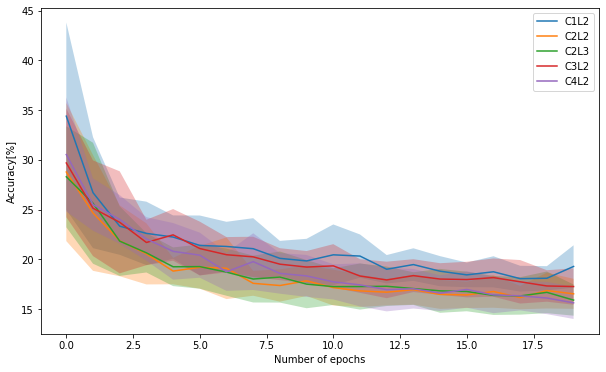

In [154]:
#models=[C1L2,C1L3,C1L5,C2L2,C2L3,C3L2,C4L2,C4L2_bis]
#model_names=['C1L2','C1L3','C1L5','C2L2','C2L3','C3L2','C4L2','C4L2_bis']

models=[C1L2,C2L2,C2L3,C3L2,C4L2]
model_names=['C1L2','C2L2','C2L3','C3L2','C4L2']
big_error_plot(models,model_names,n=20,nb_epochs=20,name='big_plot_aux=1.png')

Starting model C1L2
Mean number of errors after 20 epochs of training: tensor(180.6500) out of 1000 test samples with a standard deviation of tensor(12.9219)
Starting model C2L2
Mean number of errors after 20 epochs of training: tensor(166.5000) out of 1000 test samples with a standard deviation of tensor(15.5749)
Starting model C2L3
Mean number of errors after 20 epochs of training: tensor(179.3000) out of 1000 test samples with a standard deviation of tensor(21.8683)
Starting model C3L2
Mean number of errors after 20 epochs of training: tensor(169.3500) out of 1000 test samples with a standard deviation of tensor(10.6488)
Starting model C4L2
Mean number of errors after 20 epochs of training: tensor(168.4000) out of 1000 test samples with a standard deviation of tensor(12.5589)


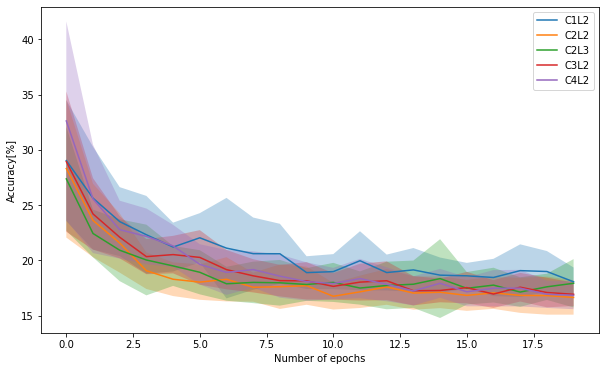

In [155]:
#Same as before with aux_factor=0.1
models=[C1L2,C2L2,C2L3,C3L2,C4L2]
model_names=['C1L2','C2L2','C2L3','C3L2','C4L2']
big_error_plot(models,model_names,n=20,nb_epochs=20,aux_factor=0.1,name='big_plot_aux=01.png')

Starting model C1L2
Mean number of errors after 20 epochs of training: tensor(191.8500) out of 1000 test samples with a standard deviation of tensor(55.4325)
Starting model C2L2
Mean number of errors after 20 epochs of training: tensor(167.5500) out of 1000 test samples with a standard deviation of tensor(8.5377)
Starting model C2L3
Mean number of errors after 20 epochs of training: tensor(183.8500) out of 1000 test samples with a standard deviation of tensor(22.6164)
Starting model C3L2
Mean number of errors after 20 epochs of training: tensor(179.1500) out of 1000 test samples with a standard deviation of tensor(14.8014)
Starting model C4L2
Mean number of errors after 20 epochs of training: tensor(182.6500) out of 1000 test samples with a standard deviation of tensor(14.2248)


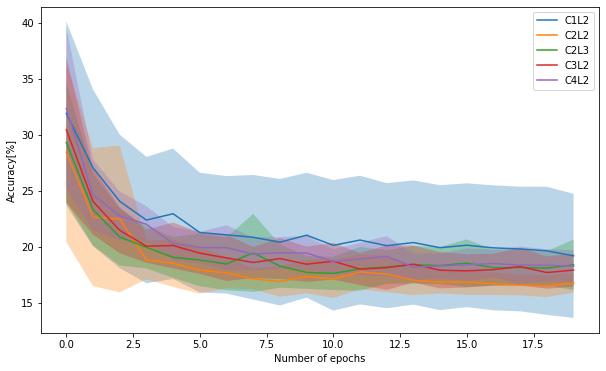

In [156]:
#Same as before with aux_factor=0
models=[C1L2,C2L2,C2L3,C3L2,C4L2]
model_names=['C1L2','C2L2','C2L3','C3L2','C4L2']
big_error_plot(models,model_names,n=20,nb_epochs=20,aux_factor=0,name='big_plot_aux=0.png')

In [139]:
model=C1L2
m=model()
mini_batch_size=10
eta=1e-3
nb_epochs=20
aux_factor=0.1
train_input,train_target,train_classes,test_input,test_target,test_classes=various_data_functions.data(N,True,False,nn.CrossEntropyLoss,shuffle=shuffle)
new_losses,new_errors=train_model(m, train_input, train_target,train_classes,mini_batch_size,test_input=test_input, test_target=test_target,crit=nn.CrossEntropyLoss,eta=eta,nb_epochs=nb_epochs,aux_factor=aux_factor,store_loss=True,store_error=True,checkpoint_name=None)

In [140]:
nb_test_errors = compute_nb_errors(m, test_input, test_target, mini_batch_size)
print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),nb_test_errors, test_input.size(0)))

test error Net 20.00% 200/1000
